# Software development patterns through git data mining


In [1]:
import sys, os, getpass, warnings
warnings.filterwarnings('ignore')
from patterns.visualizer import Visualizer

Create a `Visualizer` object for a project, e.g., for Spack, `vis = Visualizer('spack')`. This brings in data from database and annotate it with *locc*, *locc+*, *locc-*, *change-size-cos* = *1-similarity* (**expensive call**). The data is cached locally after it's fetched from the database and subsequently loaded from disk, unless you specify the `cache=False` parameter, e.g., `vis.get_data(cache=False)`. Available projects include `'lammps', 'spack', 'petsc', 'Nek5000', 'nwchem', 'E3SM', 'qmcpack', 'qdpxx', 'LATTE', 'namd', 'enzo-dev'` (the full list can be obtained with by calling the `Visualizer()` constructor without arguments.

The `get_data` method automatically removes changes associated with non-code files. The determination of what is code is made by including common suffixes, as well as checking manually a sampling of ECP projects for the suffixes used for things that can be labeled as code (vs. input simulation data, documentation, or generated files), for a list of suffixes, refer to the `Patterns.code_suffixes` list in [patterns.py](https://github.com/HPCL/ideas-uo/blob/master/src/patterns/patterns.py). This makes the analysis of decades of project data feasible. You can disable this if desired, by passing the `code_only=False` parameter to `get_data`. You can also explicitly remove non-code rows with `vis.remove_noncode()`. Optionally, you can remove files that are likely copies of external code (path contains `extern` or `contrib`) with `vis.remove_external()`.

In [2]:
vis = Visualizer(project_name='spack')
vis.get_data()

Database password: ·······


INFO: Loading spack data from database. This can take a while...
INFO: Loaded spack data from the database (exclude_forks=False, forks_only=False)
INFO: Cleaning up data and computing averages...
INFO: Done computing averages. 64909 file changes (code only)


In [3]:
removed = vis.remove_external()

INFO: Removed 406 external file changes. New total size: 64503 changes


              locc+        locc-  change-size-cos
count     33.000000    33.000000        33.000000
mean    7246.545455  1037.848485       707.121212
std     5072.146501   825.943821       751.640986
min        0.000000     0.000000         0.000000
max    17384.000000  3224.000000      3779.000000


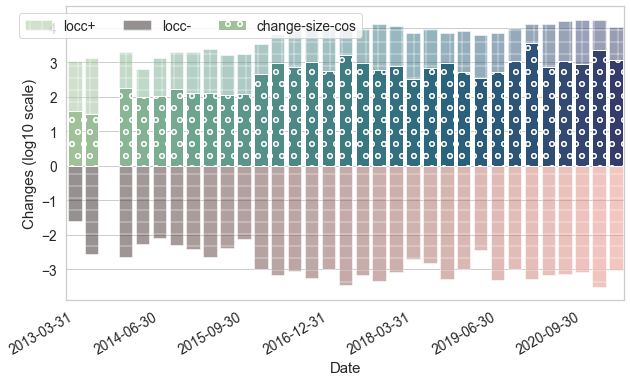

In [4]:
df = vis.plot_overall_project_locc(log=True)

to focus on a given year and/or month, set *year* and *month* fields

In [5]:
vis.set_year(2020)
vis.set_month(10)

to plot for a given year, provide *time_range='year'*

             locc+        locc-  change-size-cos
count    12.000000    12.000000        12.000000
mean   5292.000000   606.750000       417.916667
std    1091.040038   381.890542       374.582788
min    4184.000000   209.000000       217.000000
max    7088.000000  1421.000000      1573.000000


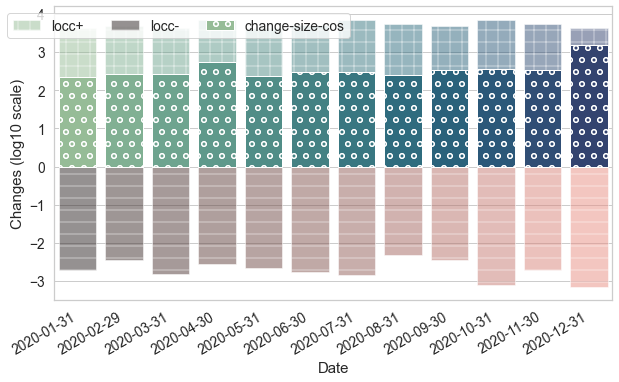

In [6]:
df = vis.plot_overall_project_locc(time_range='year',log=True)

similarly to plot for a given month, set *time_range='month'*

            locc+       locc-  change-size-cos
count   31.000000   31.000000        31.000000
mean   226.193548   41.290323        11.677419
std    185.936444   90.698840         8.799194
min     10.000000    0.000000         1.000000
max    768.000000  404.000000        43.000000


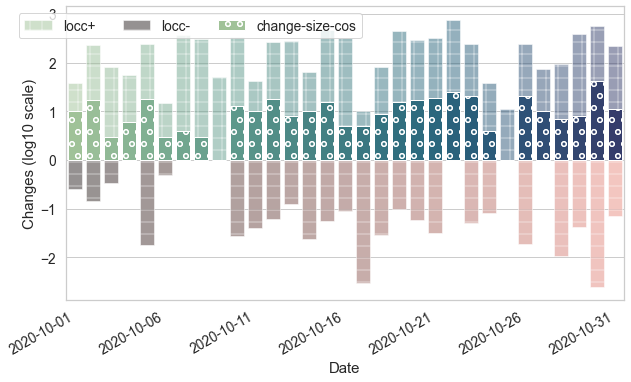

In [7]:
df = vis.plot_overall_project_locc(time_range='month',log=True)

### Finding trends with averages
We can plot the annual averages timeline for the entire project's history (by default showing LOCC and cos distance) with `plot_total_avg`. Several moving average plots are available, with different aggregation granularities (year, month) and different sliding window sizes.

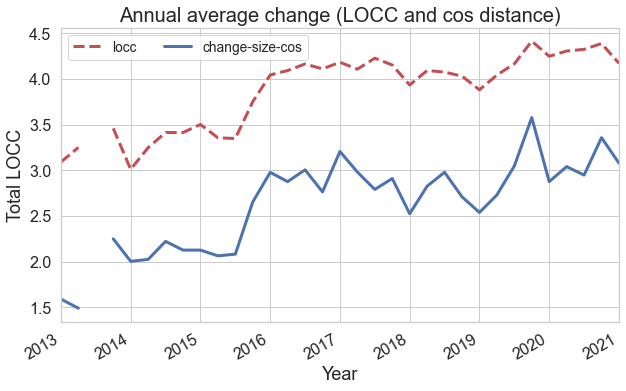

In [8]:
vis.plot_total_avg(log=True)

We can also compute different moving averages, indicating the aggregation frequency with the `freq` paramater. The default is `quarter`.

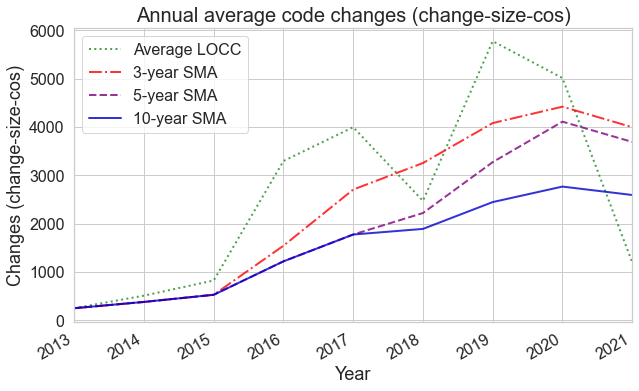

In [9]:
vis.plot_total_moving_avgs(freq='year')

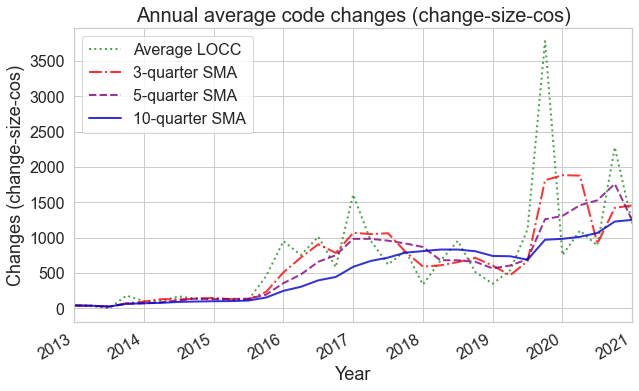

In [10]:
vis.plot_total_moving_avgs()

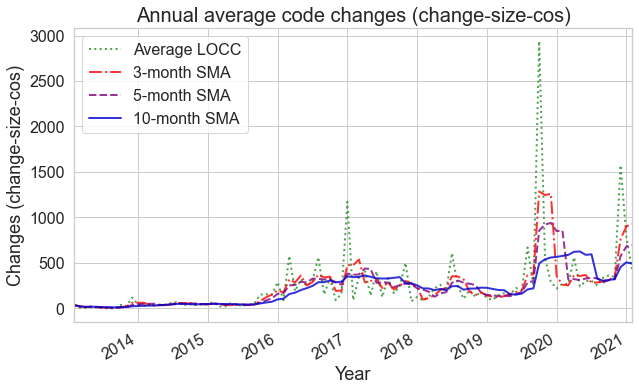

In [11]:
vis.plot_total_moving_avgs(freq='month')

## More timelines
This reflects changed lines of code as reported in git commit diffs. We have two functions that generate timeline plots of a change metric: `plot_proj_change_line` and `plot_proj_change_bubble`. By default, they show the entire range of selected dates and use the cos distance metric. You can specify a different metric with the `locc_metric` argument, e.g., `vis.plot_proj_change_line(locc_metric='locc')`

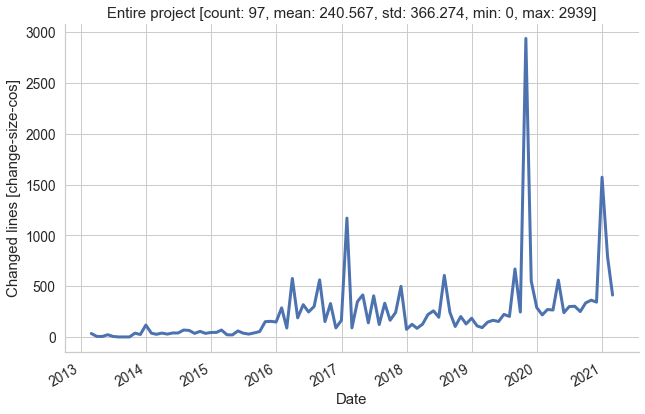

In [12]:
df = vis.plot_proj_change_line()

And looking at both line counts (LOCC) and the distance based `change-size-cos` at the same time. If not specified, the time_range argument defaults None, which indicates the entire time period of the dataset.

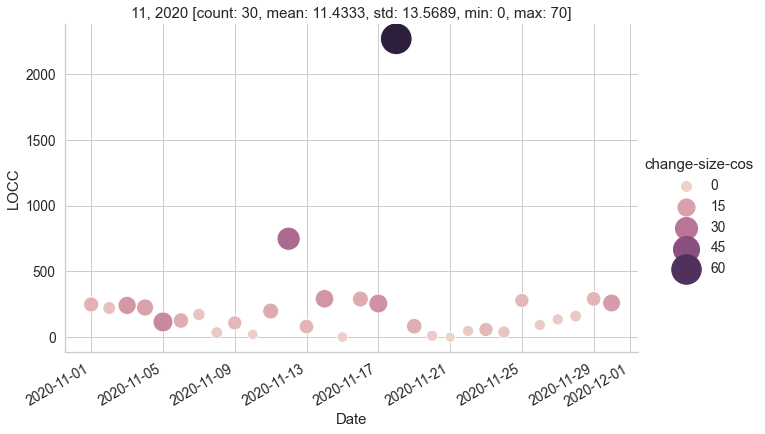

In [13]:
vis.set_month(11)
df = vis.plot_proj_change_bubble(time_range="month")

We can choose to zoom into a specific year, recall that previously we did `vis.set_year(2020)`.

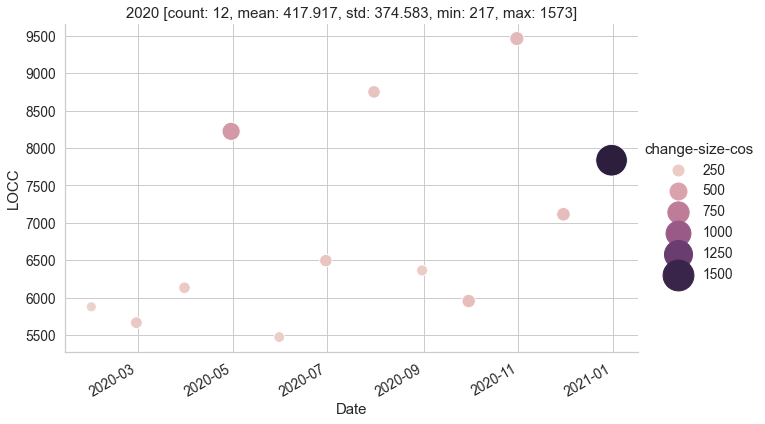

In [14]:
df = vis.plot_proj_change_bubble(time_range='year')

Or a specific year range.

              locc+        locc-  change-size-cos
count     33.000000    33.000000        33.000000
mean    7246.545455  1037.848485       707.121212
std     5072.146501   825.943821       751.640986
min        0.000000     0.000000         0.000000
max    17384.000000  3224.000000      3779.000000


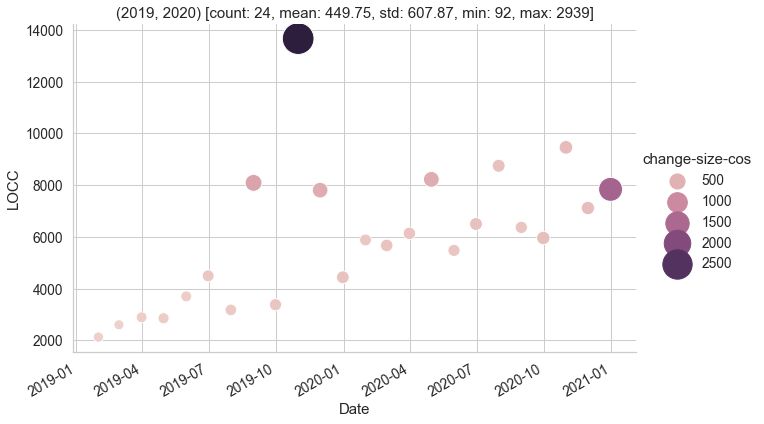

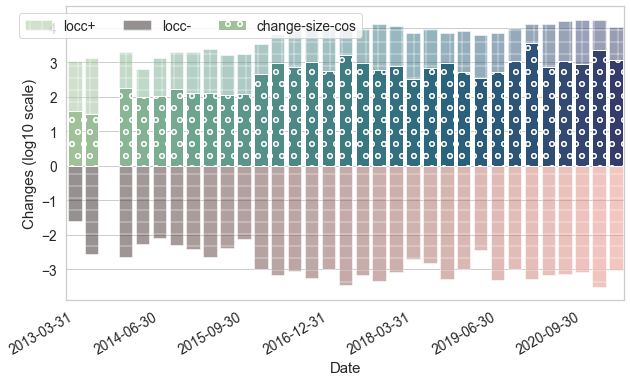

In [15]:
vis.select_year_range(2019,2020)
vis.plot_proj_change_bubble(time_range='year-year')
df = vis.plot_overall_project_locc(time_range='year-year',log=True)

We can also zoom into a single month; recall we previously did:
```
vis.set_year(2019)
vis.set_month(10)
```

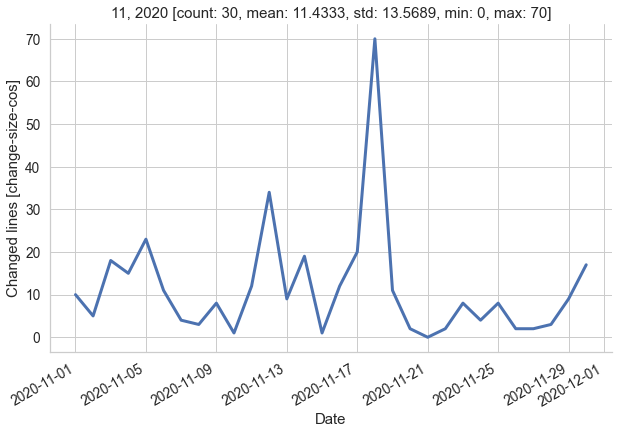

In [16]:
_ = vis.plot_proj_change_line(time_range='month')

Or a month range

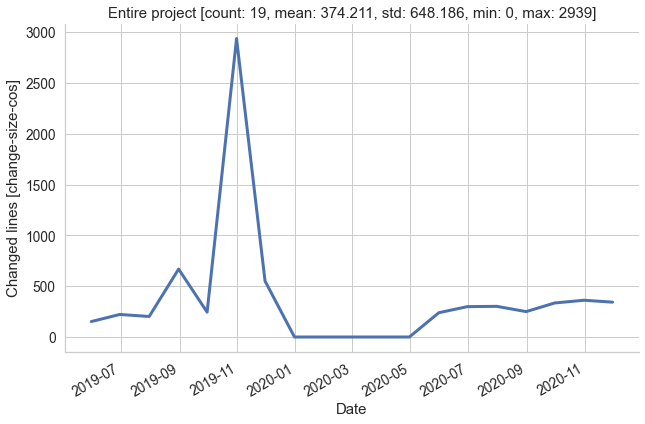

In [17]:
vis.select_month_range(5,11)
df = vis.plot_proj_change_line(time_range='month-month')

## Using a text distance metric to adjust the size of the changes

We use the python [textdistance](https://github.com/life4/textdistance) module. The following algorithms have been integrated with the visualizer.
```
'cos', 'hamming', 'damerau_levenshtein', 'jaccard', 'jaro', 'jaro_winkler', 'bag', 'editex'
```
Any of the above plots can be made with any line counting metric, typically specified through the `locc_metric` argument.

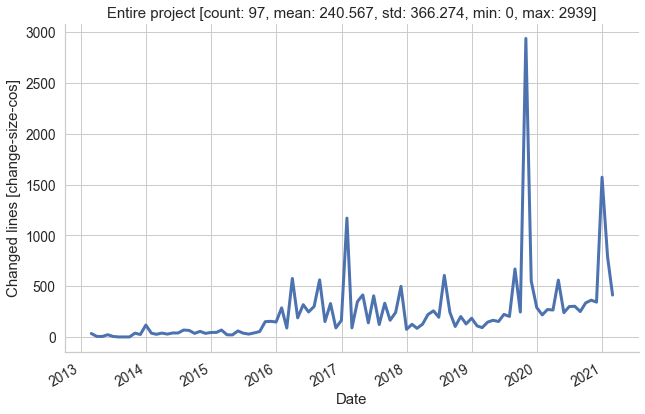

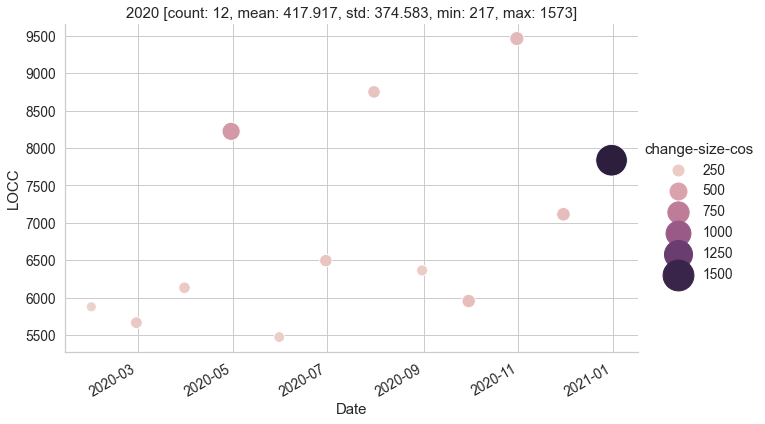

In [18]:
vis.set_diff_alg('jaccard')
df = vis.plot_proj_change_line()
_ = vis.plot_proj_change_bubble()

## More patterns
Here we look at a combination of the the high-churn and domain champion patterns. Basically we are focusing on the files that have the most changes and restricting the developers by those with the biggest contributions. One tricky issue that makes this nontrivial is that contributors use different names for their contributions. We have implemented a fuzzy name matching scheme of author names using the python `fuzzywuzzy` package to consolidate single-author contributions as much as possible.

INFO: Creating developer matrix...
INFO: Analyzing author names, this can take a few minutes...


unique_author,Todd Gamblin,Adam J. Stewart,Massimiliano Culpo,Glenn P Johnson,Greg Becker,alalazo,Peter Josef Scheibel,Scott Wittenburg,Denis Davydov,Gregory Becker
filepath,,,,,,,,,,
lib/spack/spack/config.py,970,1,60,0,5,246,15,0,0,94
lib/spack/spack/database.py,357,0,86,0,137,0,339,24,0,152
lib/spack/spack/environment.py,1246,12,101,0,169,300,138,0,3,186
lib/spack/spack/modules.py,202,0,883,5,0,472,0,0,0,3
lib/spack/spack/package.py,1972,396,290,0,234,703,152,2,17,45


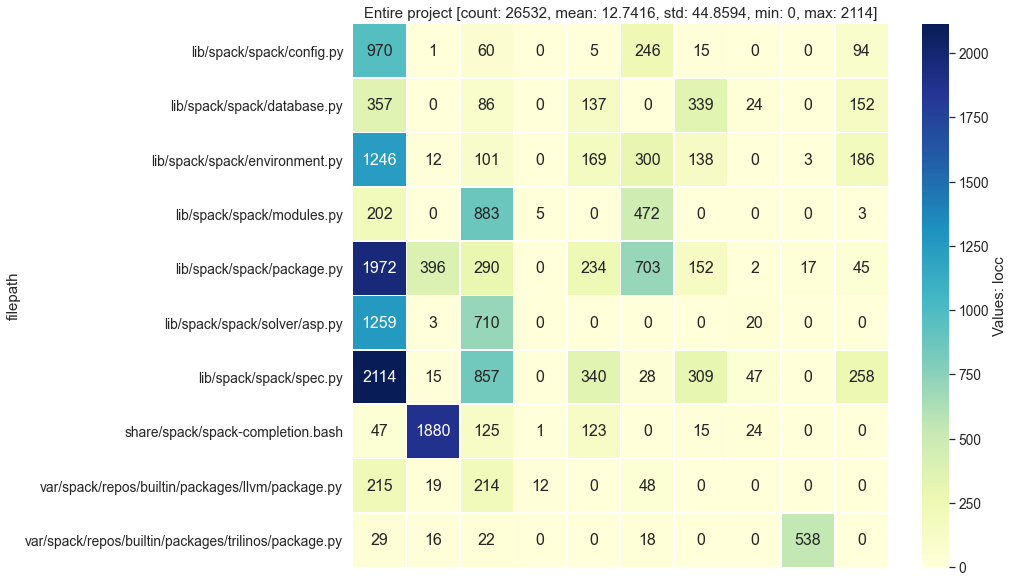

In [19]:
N = 10
vis.reset()
#vis.set_unique_authors()  # force author recomputation, this is expensive, so the result will be cached
vis.set_max_label_length(30)
top_N = vis.plot_top_N_heatmap(N, locc_metric='locc')
top_N.head()

INFO: Creating developer matrix...


unique_author,Adam J. Stewart,Todd Gamblin,Glenn P Johnson,Massimiliano Culpo,Michael Kuhn,Elizabeth Fischer,Gregory Becker,Denis Davydov,Axel Huebl,alalazo
filepath,,,,,,,,,,
lib/spack/spack/build_environment.py,16,33,0,10,0,1,20,4,0,11
lib/spack/spack/concretize.py,1,28,0,9,0,1,28,1,0,0
lib/spack/spack/environment.py,4,33,0,8,0,0,4,1,0,7
lib/spack/spack/package.py,24,169,0,27,0,10,6,1,1,35
lib/spack/spack/solver/asp.py,1,47,0,46,0,0,0,0,0,0


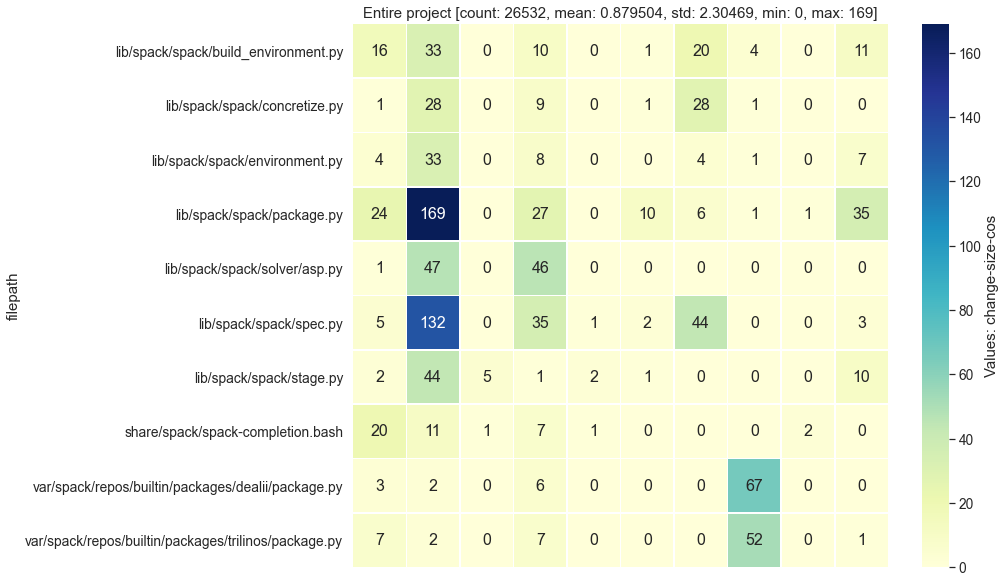

In [20]:
top_N_cos = vis.plot_top_N_heatmap(N, locc_metric='change-size-cos')
top_N_cos.head()

INFO: Creating developer matrix...


unique_author,Adam J. Stewart,Massimiliano Culpo,Axel Huebl,Greg Becker,Tamara Dahlgren,Todd Gamblin,Michael Kuhn,iarspider,Scott Wittenburg,Harmen Stoppels
filepath,,,,,,,,,,
lib/spack/spack/binary_distribution.py,0,1,0,0,2,0,0,0,9,1
lib/spack/spack/environment.py,0,1,0,9,1,1,0,0,0,0
lib/spack/spack/installer.py,1,3,1,5,12,3,1,0,5,0
lib/spack/spack/package.py,2,5,1,2,4,2,0,0,1,0
lib/spack/spack/solver/asp.py,0,44,0,0,0,30,0,0,2,1


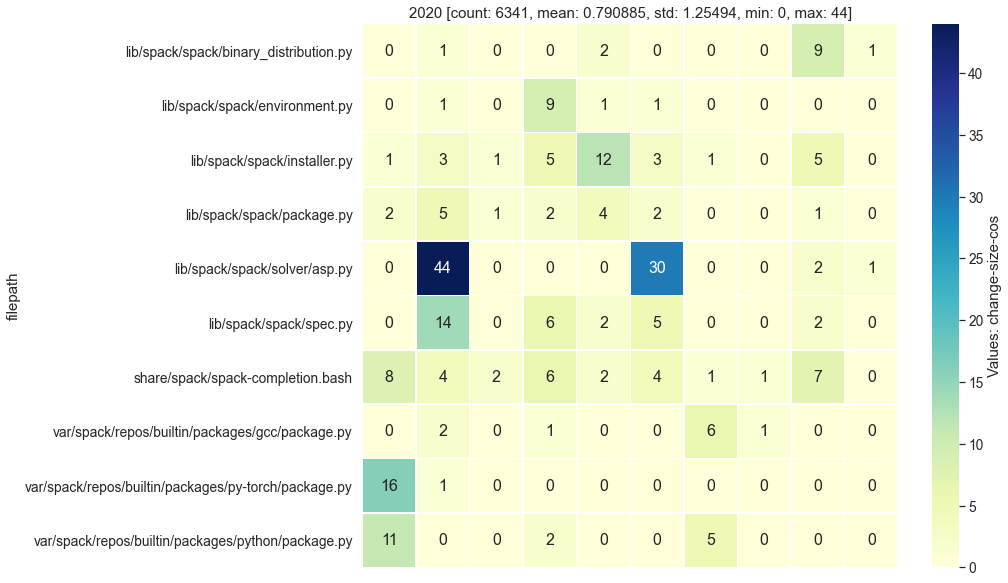

In [21]:
vis.set_year(2020)
top_N_cos = vis.plot_top_N_heatmap(N, time_range='year', locc_metric='change-size-cos')
top_N_cos.head()

We can also easily see the exact differences between different ways of measuring change. This is not something that we normally compute frequently, hence there isn't a special plot function.

In [22]:
file_dev_locc, _ = vis.make_file_developer_df(locc_metric='locc')
file_dev_diff, _ = vis.make_file_developer_df(locc_metric='change-size-cos')

INFO: Creating developer matrix...
INFO: Creating developer matrix...


Total number of developers: 759
INFO: Creating developer matrix...


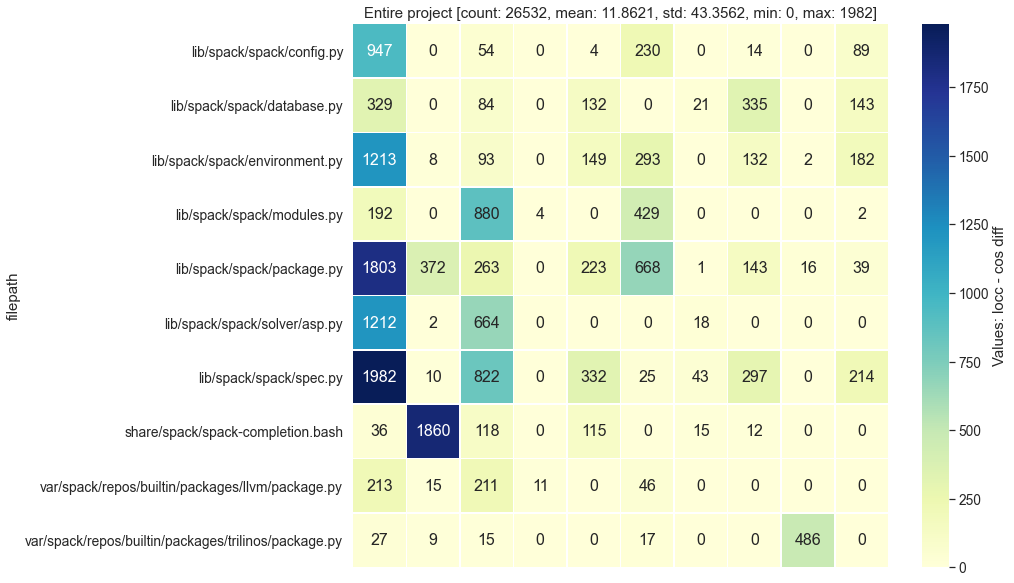

In [23]:
diff_df = file_dev_locc.sub(file_dev_diff, axis=0)
print("Total number of developers: %d" % diff_df.shape[1])
df = vis.commit_data
df['locc - cos diff'] = df['locc']-df['change-size-cos']
d = vis.plot_top_N_heatmap(top_N = 10, locc_metric='locc - cos diff', my_df=df)

We can generate the "hot-files" data for any time period, the way we select it is the same as previously described.

INFO: Creating developer matrix...


unique_author,Adam J. Stewart,Omar Padron,Greg Becker,Vivek Kale,Cyrus Harrison,Peter Josef Scheibel,Massimiliano Culpo,Marc Mengel,ktsai7,Jonathan R. Madsen
filepath,,,,,,,,,,
lib/spack/spack/concretize.py,0,0,0,0,0,0,64,0,0,0
lib/spack/spack/relocate.py,0,0,100,0,0,6,0,17,0,0
lib/spack/spack/test/util/util_url.py,0,460,0,0,0,0,0,0,0,0
lib/spack/spack/util/url.py,0,120,0,0,0,0,0,0,0,0
var/spack/repos/builtin/packages/cudnn/package.py,143,0,0,0,0,0,0,0,0,0


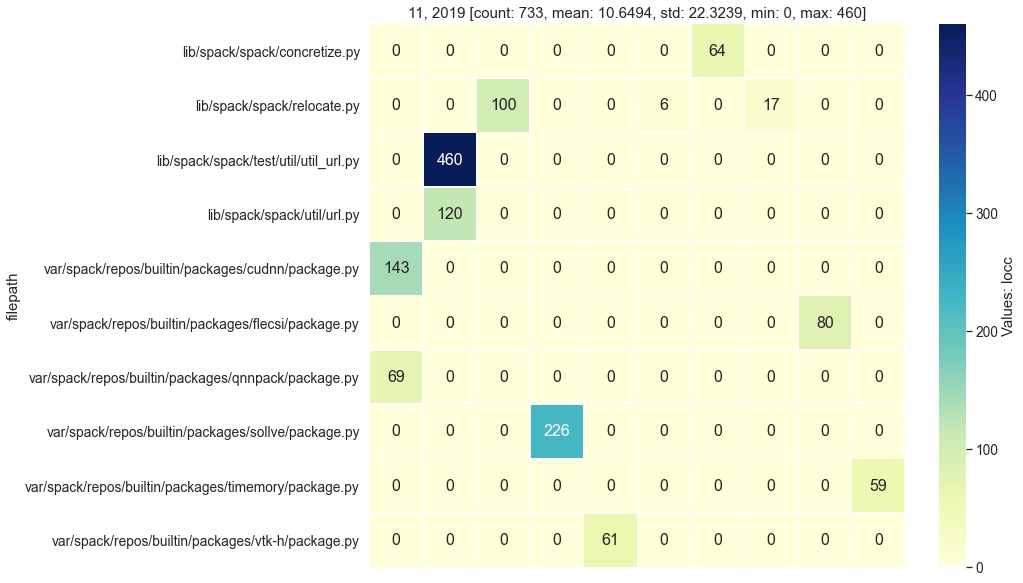

In [24]:
N = 10
vis.set_year(2019)
vis.set_month(11)
vis.set_max_label_length(30)
top_N = vis.plot_top_N_heatmap(N, time_range="month",locc_metric='locc')
top_N.head()

## In the zone
Here we look at what days of the week and times of day developers are most productive. This one also takes the usual argumemts, the defaults are `time_range=None, locc_metric='change-size-cos'`. You can choose between `'sum'` and `'mean'` for aggregating the data over the specified time range (or entire project if time range is None). Using the sum helps see when the bulk of the contributions are made, while `mean` reveals more fine-grained periods of high average productivity better.

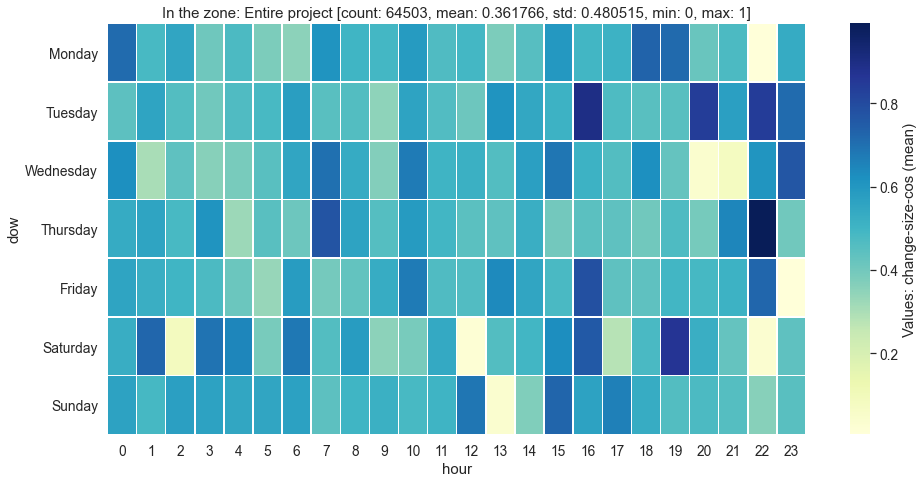

In [25]:
df = vis.plot_zone_heatmap(agg='mean')

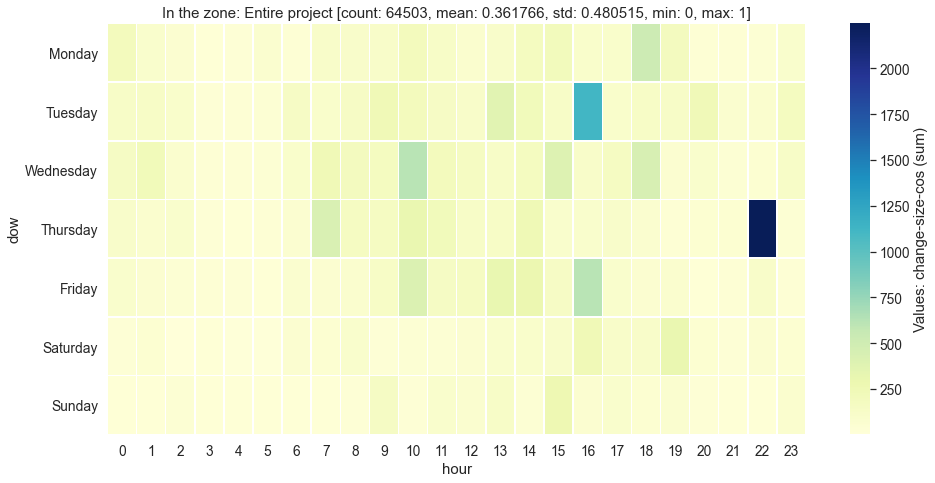

In [26]:
df = vis.plot_zone_heatmap(agg='sum')

## Did anything unusual happen in 2020?
This specific function looks at how 2020 contributions compare with the average (and the previous year).

We use the day-time heatmap again, zooming to specific years, in this case, 2019 and 2020. With `sum`, we see when most of the changes were made, while `mean` reveals when people are most productive.

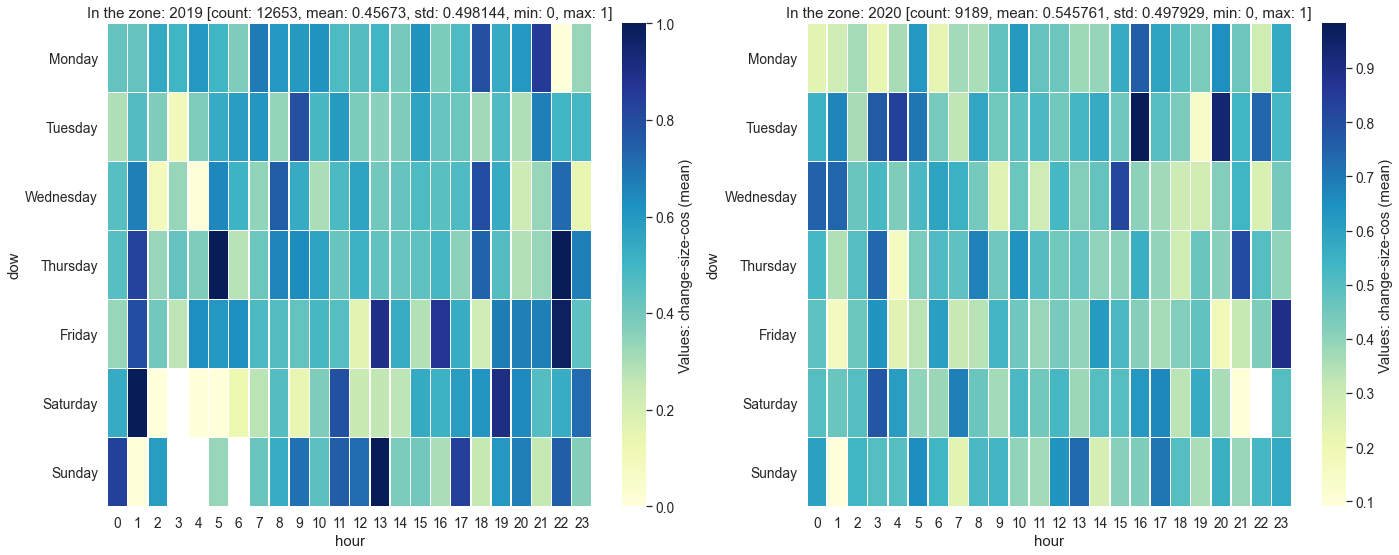

In [36]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
vis.set_year(2019)
df_2019 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[0]),agg='mean')
vis.set_year(2020)
df_2020 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[1]),agg='mean')

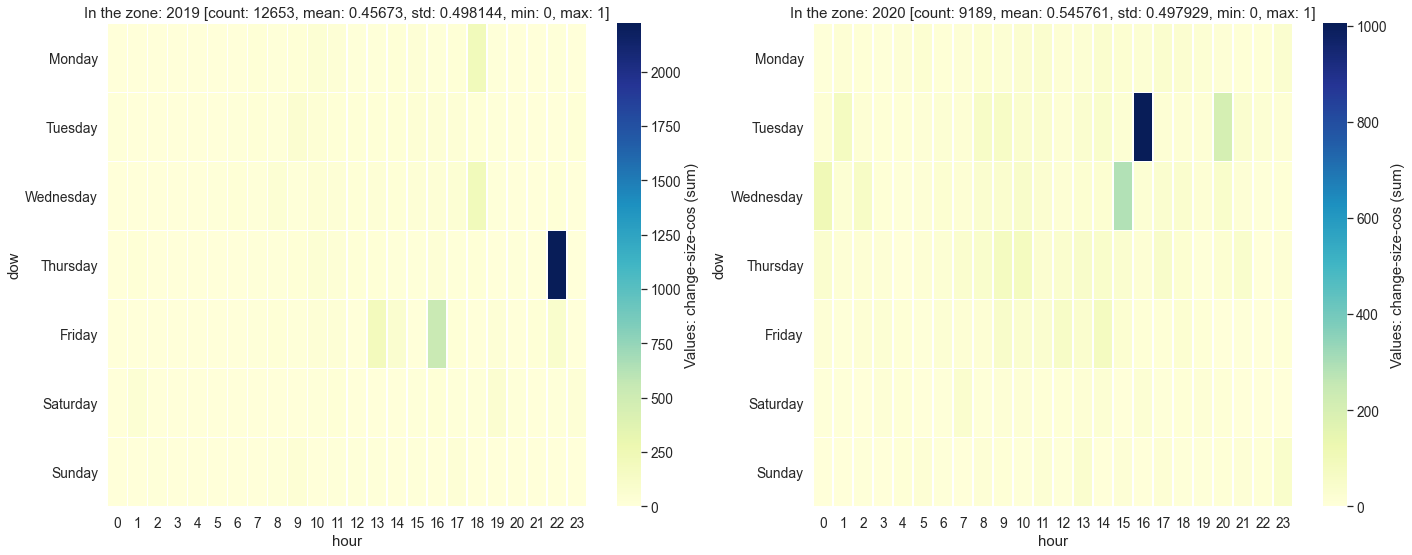

In [37]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
vis.set_year(2019)
df_2019 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[0]),agg='sum')
vis.set_year(2020)
df_2020 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[1]),agg='sum')

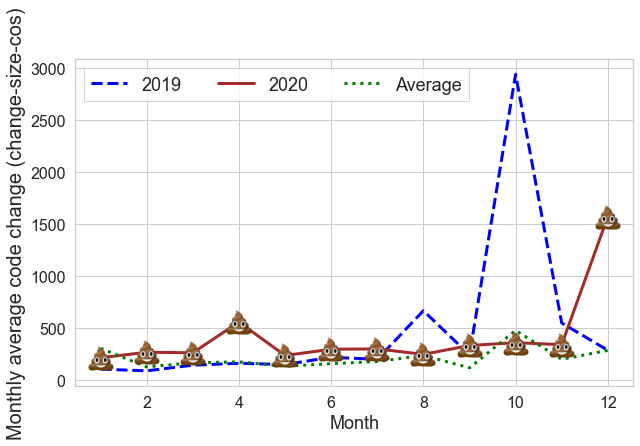

In [38]:
vis.how_was_2020('change-size-cos')

In [ ]:
vis.how_was_2020('locc')

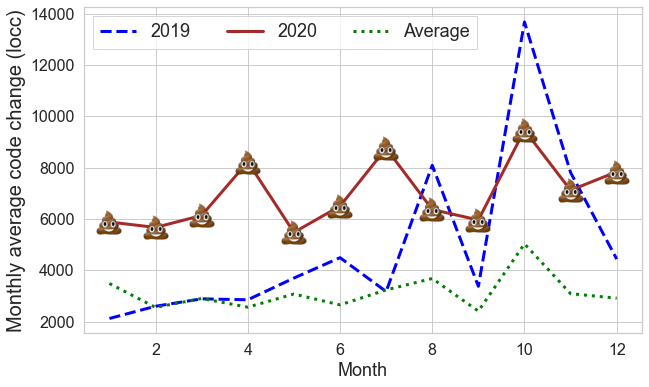

In [39]:
vis.how_was_2020('locc')